In [9]:
!pip install kornia_moons --upgrade
!pip install opencv-python
!pip install opencv-contrib-python
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [10]:
!apt update
!apt-get install libglu1 -y

Hit:1 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:2 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:3 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:4 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Reading package lists... Done3m
Building dependency tree       
Reading state information... Done
53 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'libglu1-mesa' instead of 'libglu1'
libglu1-mesa is already the newest version (9.0.1-1build1).
0 upgraded, 0 newly installed, 0 to remove and 53 not upgraded.


In [11]:
!pip install git+https://github.com/kornia/kornia

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Cloning https://github.com/kornia/kornia to /tmp/pip-req-build-820f0izz
  Running command git clone -q https://github.com/kornia/kornia /tmp/pip-req-build-820f0izz
  Resolved https://github.com/kornia/kornia to commit e65fe6c54ada355cf0d9a0ebe4e607acc02e79a7
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done


In [ ]:
!wget https://github.com/kornia/data/raw/main/matching/kn_church-2.jpg
!wget https://github.com/kornia/data/raw/main/matching/kn_church-8.jpg

--2022-03-04 16:53:34--  https://github.com/kornia/data/raw/main/matching/kn_church-2.jpg
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kornia/data/main/matching/kn_church-2.jpg [following]
--2022-03-04 16:53:36--  https://raw.githubusercontent.com/kornia/data/main/matching/kn_church-2.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 204108 (199K) [image/jpeg]
Saving to: ‘kn_church-2.jpg’

kn_church-2.jpg     100%[===================>] 199.32K  --.-KB/s    in 0.008s  

2022-03-04 16:53:36 (24.6 MB/s) - ‘kn_church-2.jpg’ saved [204108/204108]

--2022-03-04 16:53:37--  https://github.com/korn

In [12]:
import matplotlib.pyplot as plt
import cv2
import kornia as K
import kornia.feature as KF
import numpy as np
import torch
from kornia_moons.feature import *
from ipywidgets import FloatProgress

'''def load_torch_image(fname):
    img = K.image_to_tensor(cv2.imread(fname), False).float() /255.
    img = K.color.bgr_to_rgb(img)
    return img'''
def resize(scale,img):
    scale_percent = scale  # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
    return resized

def load_torch_image(fname,s):
    img= cv2.imread(fname)
    img=resize(s,img)
    img = K.image_to_tensor(img, False).float() /255.
    img = K.color.bgr_to_rgb(img)
    return img

In [13]:
fname1 = 'kn_church-2.jpg'
fname2 = 'kn_church-8.jpg'

img1 = load_torch_image(fname1,30)
img2 = load_torch_image(fname2,30)


matcher = KF.LoFTR(pretrained='outdoor')

input_dict = {"image0": K.color.rgb_to_grayscale(img1), # LofTR works on grayscale images only 
              "image1": K.color.rgb_to_grayscale(img2)}

with torch.no_grad():
    correspondences = matcher(input_dict)

/opt/conda/lib/python3.8/site-packages/kornia/feature/loftr/utils/coarse_matching.py:255: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  [i_ids % data['hw0_c'][1], i_ids // data['hw0_c'][1]],
/opt/conda/lib/python3.8/site-packages/kornia/feature/loftr/utils/coarse_matching.py:258: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  [j_ids % 

In [14]:
for k,v in correspondences.items():
    print (k)

keypoints0
keypoints1
confidence
batch_indexes


In [15]:
mkpts0 = correspondences['keypoints0'].cpu().numpy()
mkpts1 = correspondences['keypoints1'].cpu().numpy()
H, inliers = cv2.findFundamentalMat(mkpts0, mkpts1, cv2.USAC_MAGSAC, 0.5, 0.999, 100000)
inliers = inliers > 0

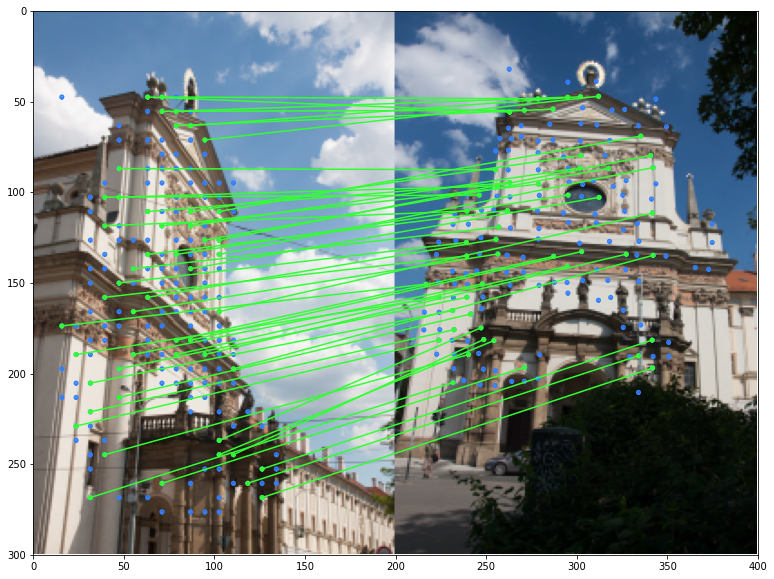

In [16]:
draw_LAF_matches(
    KF.laf_from_center_scale_ori(torch.from_numpy(mkpts0).view(1,-1, 2),
                                torch.ones(mkpts0.shape[0]).view(1,-1, 1, 1),
                                torch.ones(mkpts0.shape[0]).view(1,-1, 1)),

    KF.laf_from_center_scale_ori(torch.from_numpy(mkpts1).view(1,-1, 2),
                                torch.ones(mkpts1.shape[0]).view(1,-1, 1, 1),
                                torch.ones(mkpts1.shape[0]).view(1,-1, 1)),
    torch.arange(mkpts0.shape[0]).view(-1,1).repeat(1,2),
    K.tensor_to_image(img1),
    K.tensor_to_image(img2),
    inliers,
    draw_dict={'inlier_color': (0.2, 1, 0.2),
               'tentative_color': None, 
               'feature_color': (0.2, 0.5, 1), 'vertical': False})